- This is a comprehensive example of a TVM Unity workflow. We set up the model import, tuning, and benchmarking. 

- We do a direct comparison between the untuned and tuned performance of the ResNet50 model. 

- We dive into TVM's meta_schedule! This is a powerful, next-generation auto-tuning framework in TVM Unity that supersedes older systems like AutoTVM and Ansor.

- We also visualize the differences in the IR of the tuned versus original model


In [1]:
import tvm
from tvm import relax, meta_schedule as ms
from tvm.relax import Expr, Function
from tvm.ir import IRModule
from tvm.script import relax as R
from tvm.target import Target
from tvm.relax.frontend.onnx import from_onnx
from tvm.relax.transform import LegalizeOps, FuseOps, RunCodegen
from tvm.runtime import NDArray

import numpy as np
import onnx
import time
import matplotlib.pyplot as plt
import os
import shutil

#https://tvm.apache.org/docs/v0.13.0/tutorial/tvmc_command_line_driver.html

For this, we will be working with ResNet-50 v2. 
ResNet-50 is a convolutional neural network that is 50 layers deep and designed to classify images. The model has been pre-trained on more than a million images with 1000 different classifications. The network has an input image size of 224x224. 

Note: If interested in exploring more of how the ResNet-50 model is structured, download Netron, a freely available ML model viewer.

In [2]:
# ---* Step 1: Download the ONNX model *---
# Note: The exclamation mark (!) tells the shell to run the command not Python.
# We first check if the file exists to avoid re-downloading.

if not os.path.exists("perf_files/resnet50-v2-7.onnx"):
    print("Downloading ResNet50-v2-7 ONNX model...")
    os.system("curl -L -o resnet50-v2-7.onnx https://github.com/onnx/models/raw/b9a54e89508f101a1611cd64f4ef56b9cb62c7cf/vision/classification/resnet/model/resnet50-v2-7.onnx")

print("resnet50-v2-7.onnx exists:", os.path.exists("perf_files/resnet50-v2-7.onnx"))



resnet50-v2-7.onnx exists: True


In [3]:
# ---* Step 2: Load the ONNX model and convert to Relax IRModule *---

print("\nLoading and checking ONNX model...")
onnx_model = onnx.load("perf_files/resnet50-v2-7.onnx")
onnx.checker.check_model(onnx_model)
print("ONNX model is valid.")
print(tvm.__version__)


Loading and checking ONNX model...
ONNX model is valid.
0.22.dev0


In [4]:
# Define input shapes for the model. The model expects an input named "data".

input_shapes = {"data": (1, 3, 224, 224)}
# Convert the ONNX model to TVM's Relax IRModule.
mod = from_onnx(onnx_model, input_shapes)
# Print out the IRModule
#print(mod)

In [5]:
# ---* Step 3: Apply Relax optimizations *---
target = Target("llvm -num-cores 4")  # Or your mac target, e.g., "apple/gpu"

print("\nApplying Relax optimizations...")
mod = relax.transform.Normalize()(mod)
mod = LegalizeOps()(mod)  
mod = FuseOps()(mod)      
mod = RunCodegen({"relay": {"target": target}})(mod) 

# ---* Step 4: Build and benchmark the untuned model *---
print("\nBuilding and benchmarking the untuned model...")
dev = tvm.cpu()
ex_untuned = relax.build(mod, target)
vm_untuned = relax.VirtualMachine(ex_untuned, dev)

input_data = np.random.rand(1, 3, 224, 224).astype("float32")
input_tvm = tvm.nd.array(input_data)
# Warm-up run
vm_untuned["main"](input_tvm)

# Time the untuned model
ftimer = vm_untuned.module.time_evaluator("main", dev, number=10, repeat=3)
prof_res = ftimer(input_tvm)
untuned_time_ms = np.median(prof_res.results) * 1000
print("Untuned Time: %.2f ms" % untuned_time_ms)


# ---* Step 5: Tune the TIR with MetaSchedule *---
# NOTE: This tuning step can take a long time to run.
# The results are saved to the "tuning_logs" directory so you only need to run this once.
if os.path.exists("./tuning_logs"):
    print("\nRemoving old 'tuning_logs' directory to prevent potential corruption issues.")
    shutil.rmtree("./tuning_logs")

print("\nStarting Meta-Schedule tuning. This may take a while...")
database = ms.tune_tir(
    mod=mod,
    target=target,
    work_dir="./tuning_logs",  # Restoring this required argument.
    max_trials_global=512,
)
print("\nTuning complete. Database saved to './tuning_logs'.")



Applying Relax optimizations...

Building and benchmarking the untuned model...
Untuned Time: 2389.16 ms

Removing old 'tuning_logs' directory to prevent potential corruption issues.

Starting Meta-Schedule tuning. This may take a while...
2025-08-06 22:06:58 [INFO] Logging directory: ./tuning_logs/logs
2025-08-06 22:07:02 [INFO] LocalBuilder: max_workers = 14
2025-08-06 22:07:03 [INFO] LocalRunner: max_workers = 1
2025-08-06 22:07:04 [INFO] [task_scheduler.cc:167] Initializing Task #0: "add"
2025-08-06 22:07:04 [INFO] [task_scheduler.cc:167] Initializing Task #1: "add1"
2025-08-06 22:07:04 [INFO] [task_scheduler.cc:167] Initializing Task #2: "add2"
2025-08-06 22:07:04 [INFO] [task_scheduler.cc:167] Initializing Task #3: "add3"
2025-08-06 22:07:04 [INFO] [task_scheduler.cc:167] Initializing Task #4: "add4"
2025-08-06 22:07:04 [INFO] [task_scheduler.cc:167] Initializing Task #5: "batch_norm"
2025-08-06 22:07:04 [INFO] [task_scheduler.cc:167] Initializing Task #6: "batch_norm1"
2025-08-

[22:07:05] /Users/hafsahshahzad/tvm/src/meta_schedule/schedule_rule/apply_custom_rule.cc:59: Warning: Unknown schedule rule "meta_schedule.pool_max" for target keys "["arm_cpu", "cpu"]". Checked ffi::Functions:
  meta_schedule.arm_cpu.meta_schedule.pool_max
  meta_schedule.cpu.meta_schedule.pool_max


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,N/A,N/A,N/A,0,
1,add1,401408,1,N/A,N/A,N/A,0,
2,add2,200704,1,N/A,N/A,N/A,0,
3,add3,100352,1,N/A,N/A,N/A,0,
4,add4,1000,1,N/A,N/A,N/A,0,
5,batch_norm,1354779,1,N/A,N/A,N/A,0,
6,batch_norm1,7225920,1,N/A,N/A,N/A,0,
7,batch_norm10,907776,1,N/A,N/A,N/A,0,
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,



Total trials: 0
Total latency (us): 0

2025-08-06 22:07:05 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |            N/A |          N/A |                   N/A |      0 |      
  1 |         add1 |    401408 |      1 |            N/A |          N/A |                   N/A |      0 |      
  2 |         add2 |    200704 |      1 |            N/A |          N/A |                   N/A |      0 |      
  3 |         add3 |    100352 |      1 |            N/A |          N/A |                   N/A |      0 |      
  4 |         add4 |      1000 |      1 |            N/A |          N/A |                   N/A |      0 |      
  5 |   batch_norm |   1354779 |      1 |            N/A |          N/A |                   N/A |      0 |      
  6

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,
1,add1,401408,1,N/A,N/A,N/A,0,
2,add2,200704,1,N/A,N/A,N/A,0,
3,add3,100352,1,N/A,N/A,N/A,0,
4,add4,1000,1,N/A,N/A,N/A,0,
5,batch_norm,1354779,1,N/A,N/A,N/A,0,
6,batch_norm1,7225920,1,N/A,N/A,N/A,0,
7,batch_norm10,907776,1,N/A,N/A,N/A,0,
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,



Total trials: 1
Total latency (us): 103.766

2025-08-06 22:11:31 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |      
  1 |         add1 |    401408 |      1 |            N/A |          N/A |                   N/A |      0 |      
  2 |         add2 |    200704 |      1 |            N/A |          N/A |                   N/A |      0 |      
  3 |         add3 |    100352 |      1 |            N/A |          N/A |                   N/A |      0 |      
  4 |         add4 |      1000 |      1 |            N/A |          N/A |                   N/A |      0 |      
  5 |   batch_norm |   1354779 |      1 |            N/A |          N/A |                   N/A |      0 |    

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,N/A,N/A,N/A,0,
2,add2,200704,1,N/A,N/A,N/A,0,
3,add3,100352,1,N/A,N/A,N/A,0,
4,add4,1000,1,N/A,N/A,N/A,0,
5,batch_norm,1354779,1,N/A,N/A,N/A,0,
6,batch_norm1,7225920,1,N/A,N/A,N/A,0,
7,batch_norm10,907776,1,N/A,N/A,N/A,0,
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,



Total trials: 1
Total latency (us): 103.766

2025-08-06 22:11:31 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |            N/A |          N/A |                   N/A |      0 |      
  2 |         add2 |    200704 |      1 |            N/A |          N/A |                   N/A |      0 |      
  3 |         add3 |    100352 |      1 |            N/A |          N/A |                   N/A |      0 |      
  4 |         add4 |      1000 |      1 |            N/A |          N/A |                   N/A |      0 |      
  5 |   batch_norm |   1354779 |      1 |            N/A |          N/A |                   N/A |      0 |    

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,
2,add2,200704,1,N/A,N/A,N/A,0,
3,add3,100352,1,N/A,N/A,N/A,0,
4,add4,1000,1,N/A,N/A,N/A,0,
5,batch_norm,1354779,1,N/A,N/A,N/A,0,
6,batch_norm1,7225920,1,N/A,N/A,N/A,0,
7,batch_norm10,907776,1,N/A,N/A,N/A,0,
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,


2025-08-06 22:11:32 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |      
  2 |         add2 |    200704 |      1 |            N/A |          N/A |                   N/A |      0 |      
  3 |         add3 |    100352 |      1 |            N/A |          N/A |                   N/A |      0 |      
  4 |         add4 |      1000 |      1 |            N/A |          N/A |                   N/A |      0 |      
  5 |   batch_norm |   1354779 |      1 |            N/A |          N/A |                   N/A |      0 |      
  6 |  batch_norm1 |   7225920 |      1 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,N/A,N/A,N/A,0,
3,add3,100352,1,N/A,N/A,N/A,0,
4,add4,1000,1,N/A,N/A,N/A,0,
5,batch_norm,1354779,1,N/A,N/A,N/A,0,
6,batch_norm1,7225920,1,N/A,N/A,N/A,0,
7,batch_norm10,907776,1,N/A,N/A,N/A,0,
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,



Total trials: 2
Total latency (us): 117.182

2025-08-06 22:11:32 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |            N/A |          N/A |                   N/A |      0 |      
  3 |         add3 |    100352 |      1 |            N/A |          N/A |                   N/A |      0 |      
  4 |         add4 |      1000 |      1 |            N/A |          N/A |                   N/A |      0 |      
  5 |   batch_norm |   1354779 |      1 |            N/A |          N/A |                   N/A |      0 |    

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,
3,add3,100352,1,N/A,N/A,N/A,0,
4,add4,1000,1,N/A,N/A,N/A,0,
5,batch_norm,1354779,1,N/A,N/A,N/A,0,
6,batch_norm1,7225920,1,N/A,N/A,N/A,0,
7,batch_norm10,907776,1,N/A,N/A,N/A,0,
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,



Total trials: 3
Total latency (us): 126.316

2025-08-06 22:11:32 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |      
  3 |         add3 |    100352 |      1 |            N/A |          N/A |                   N/A |      0 |      
  4 |         add4 |      1000 |      1 |            N/A |          N/A |                   N/A |      0 |      
  5 |   batch_norm |   1354779 |      1 |            N/A |          N/A |                   N/A |      0 |    

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,N/A,N/A,N/A,0,
4,add4,1000,1,N/A,N/A,N/A,0,
5,batch_norm,1354779,1,N/A,N/A,N/A,0,
6,batch_norm1,7225920,1,N/A,N/A,N/A,0,
7,batch_norm10,907776,1,N/A,N/A,N/A,0,
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,



Total trials: 3
Total latency (us): 126.316

2025-08-06 22:11:32 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |            N/A |          N/A |                   N/A |      0 |      
  4 |         add4 |      1000 |      1 |            N/A |          N/A |                   N/A |      0 |      
  5 |   batch_norm |   1354779 |      1 |            N/A |          N/A |                   N/A |      0 |    

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,
4,add4,1000,1,N/A,N/A,N/A,0,
5,batch_norm,1354779,1,N/A,N/A,N/A,0,
6,batch_norm1,7225920,1,N/A,N/A,N/A,0,
7,batch_norm10,907776,1,N/A,N/A,N/A,0,
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,



Total trials: 4
Total latency (us): 135.493

2025-08-06 22:11:32 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |      
  4 |         add4 |      1000 |      1 |            N/A |          N/A |                   N/A |      0 |      
  5 |   batch_norm |   1354779 |      1 |            N/A |          N/A |                   N/A |      0 |    

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,N/A,N/A,N/A,0,
5,batch_norm,1354779,1,N/A,N/A,N/A,0,
6,batch_norm1,7225920,1,N/A,N/A,N/A,0,
7,batch_norm10,907776,1,N/A,N/A,N/A,0,
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,



Total trials: 4
Total latency (us): 135.493

2025-08-06 22:11:32 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |            N/A |          N/A |                   N/A |      0 |      
  5 |   batch_norm |   1354779 |      1 |            N/A |          N/A |                   N/A |      0 |    

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,
5,batch_norm,1354779,1,N/A,N/A,N/A,0,
6,batch_norm1,7225920,1,N/A,N/A,N/A,0,
7,batch_norm10,907776,1,N/A,N/A,N/A,0,
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,


2025-08-06 22:11:32 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |      
  5 |   batch_norm |   1354779 |      1 |            N/A |          N/A |                   N/A |      0 |      
  6 |  batch_norm1 |   7225920 |      1 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,N/A,N/A,N/A,0,
6,batch_norm1,7225920,1,N/A,N/A,N/A,0,
7,batch_norm10,907776,1,N/A,N/A,N/A,0,
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,



Total trials: 5
Total latency (us): 147.253

2025-08-06 22:11:32 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |            N/A |          N/A |                   N/A |      0 |    

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,
6,batch_norm1,7225920,1,N/A,N/A,N/A,0,
7,batch_norm10,907776,1,N/A,N/A,N/A,0,
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,



Total trials: 69
Total latency (us): 189.886

2025-08-06 22:11:32 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |   

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,N/A,N/A,N/A,0,
7,batch_norm10,907776,1,N/A,N/A,N/A,0,
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,



Total trials: 69
Total latency (us): 189.886

2025-08-06 22:11:32 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |   

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,
7,batch_norm10,907776,1,N/A,N/A,N/A,0,
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,


2025-08-06 22:11:32 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |    Y 
  6 |  batch_norm1 |   7225920 |      1 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,N/A,N/A,N/A,0,
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,



Total trials: 133
Total latency (us): 273.51

2025-08-06 22:11:32 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |   

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,



Total trials: 196
Total latency (us): 305.306

2025-08-06 22:11:32 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,N/A,N/A,N/A,0,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,



Total trials: 196
Total latency (us): 305.306

2025-08-06 22:11:32 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,
9,batch_norm12,921600,1,N/A,N/A,N/A,0,



Total trials: 260
Total latency (us): 339.374

2025-08-06 22:11:32 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,N/A,N/A,N/A,0,



Total trials: 260
Total latency (us): 339.374

2025-08-06 22:11:32 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,



Total trials: 323
Total latency (us): 371.084

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 323
Total latency (us): 371.084

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 387
Total latency (us): 414.98

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |   

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 387
Total latency (us): 414.98

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |   

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 451
Total latency (us): 486.211

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 451
Total latency (us): 486.211

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y


2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |    Y 
  6 |  batch_norm1 |   7225920 |      1 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,add,802816,1,7.7368,103.7663,103.7663,1,Y
1,add1,401408,1,29.9198,13.4162,13.4162,1,Y
2,add2,200704,1,21.9748,9.1334,9.1334,1,Y
3,add3,100352,1,10.9353,9.1769,9.1769,1,Y
4,add4,1000,1,0.0850,11.7602,11.7602,1,Y
5,batch_norm,1354779,1,31.7780,42.6326,42.6326,64,Y
6,batch_norm1,7225920,1,86.4095,83.6242,83.6242,64,Y
7,batch_norm10,907776,1,28.5502,31.7958,31.7958,63,Y
8,batch_norm11,230400,1,6.7628,34.0689,34.0689,64,Y
9,batch_norm12,921600,1,29.0640,31.7093,31.7093,63,Y



Total trials: 514
Total latency (us): 531.258

2025-08-06 22:11:33 [DEBUG] [task_scheduler.cc:326] 
 ID |         Name |      FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
----------------------------------------------------------------------------------------------------------------
  0 |          add |    802816 |      1 |         7.7368 |     103.7663 |              103.7663 |      1 |    Y 
  1 |         add1 |    401408 |      1 |        29.9198 |      13.4162 |               13.4162 |      1 |    Y 
  2 |         add2 |    200704 |      1 |        21.9748 |       9.1334 |                9.1334 |      1 |    Y 
  3 |         add3 |    100352 |      1 |        10.9353 |       9.1769 |                9.1769 |      1 |    Y 
  4 |         add4 |      1000 |      1 |         0.0850 |      11.7602 |               11.7602 |      1 |    Y 
  5 |   batch_norm |   1354779 |      1 |        31.7780 |      42.6326 |               42.6326 |     64 |  

In [6]:
# ---* Step 6: Re-build and benchmark the tuned model *---
import numpy as np
import tvm
from tvm import relax
#Option A uses the built‐in Relax pipeline. By setting total_trials=0 you tell 
#it “don’t re‐tune, just apply the saved schedules in tuning_logs.” Option B shows
#how to manually insert the MetaScheduleApplyDatabase pass if you prefer.Build with
#the same relax.build(...) you used before. Under the hood it picks up your tuned schedules.
#Warm up the VM (run once, to JIT, cache, etc.) and then use time_evaluator to get a stable median over multiple repeats.


# ─── i. Apply your tuning logs ────────────────────────────────────────────────
# Option A: Use the static_shape_tuning pipeline in “apply‐only” mode:
apply_only = relax.get_pipeline(
    "static_shape_tuning",
    target=target,
    total_trials=0,      # skip any new tuning
    work_dir="tuning_logs"
)
mod_tuned = apply_only(mod)

# ─── ii. Build the tuned module ───────────────────────────────────────────────
dev = tvm.device(str(target), 0)
ex_tuned = relax.build(mod_tuned, target=target)
vm_tuned = relax.VirtualMachine(ex_tuned, dev)

# ─── iii. Warm up & time it ────────────────────────────────────────────────────
# (reuse the same input_tvm you used for the untuned run)
vm_tuned["main"](input_tvm)  # warm-up

ftimer = vm_tuned.module.time_evaluator(
    "main", dev, number=10, repeat=3
)
res = ftimer(input_tvm)
tuned_time_ms = float(np.median(res.results) * 1000)

print(f"Tuned model inference: {tuned_time_ms:.2f} ms")

[22:11:33] /Users/hafsahshahzad/tvm/src/relax/transform/meta_schedule.cc:90: Warning: Creating JSONDatabase. Workload at: tuning_logs/database_workload.json, Tuning records at: tuning_logs/database_tuning_record.json


Tuned model inference: 2458.98 ms


ScratchPad ---what else i tried and does not work especially for TVM version 0.22.dev0...need to fix in the original open source repo....
# inject the ApplyDatabase pass:
from tvm.ir.transform import MetaScheduleApplyDatabase
mod_opt = transform.Sequential([
    MetaScheduleApplyDatabase("tuning_logs")
])(mod)

# build and benchmark mod_opt
ex_opt   = relax.build(mod_opt, target=target)
vm_opt   = relax.VirtualMachine(ex_opt, tvm.device(str(target), 0))
vm_opt["main"](input_tvm)  # warm up
ft_opt   = vm_opt.module.time_evaluator("main", tvm.device(str(target), 0), number=10, repeat=3)
res_opt  = ft_opt(input_tvm)
tuned_ms = float(np.median(res_opt.results) * 1000)
print(f"Tuned (via ApplyDatabase) Time: {tuned_ms:.2f} ms")

Error: ImportError: cannot import name 'MetaScheduleApplyDatabase' from 'tvm.ir.transform' (/Users/hafsahshahzad/tvm/python/tvm/ir/transform.py)


from tvm.meta_schedule.tir_integration import ApplyDatabase

# 1) load your JSON tuning logs:
db = JSONDatabase(
    path_workload      = "tuning_logs/workloads",
    path_tuning_record = "tuning_logs/records",
)

# 2) create a CMake‐style pass to apply them:
apply_pass = ApplyDatabase("tuning_logs")

# 3) wrap that in a TVM transform.Sequentia l
seq = transform.Sequential([
    relax.transform.Normalize(),      # your usual front‐end passes
    ApplyDatabase("tuning_logs"),     # ← this will apply the best found schedules
])

# 4) run it on your original IRModule:
mod_tuned = seq(mod)

# 5) build and benchmark as before:
dev      = tvm.device(str(target), 0)
ex_tuned = relax.build(mod_tuned, target=target)
vm_tuned = relax.VirtualMachine(ex_tuned, dev)
vm_tuned["main"](input_tvm)      # warm up
ft        = vm_tuned.module.time_evaluator("main", dev, number=10, repeat=3)
res       = ft(input_tvm)
print("Tuned Time = %.2f ms" % (res.mean * 1e3))


Error: ImportError: cannot import name 'ApplyDatabase' from 'tvm.meta_schedule.tir_integration' (/Users/hafsahshahzad/tvm/python/tvm/meta_schedule/tir_integration.py)
since ApplyDatabase isn't available in your current TVM build


Generating performance comparison plot...


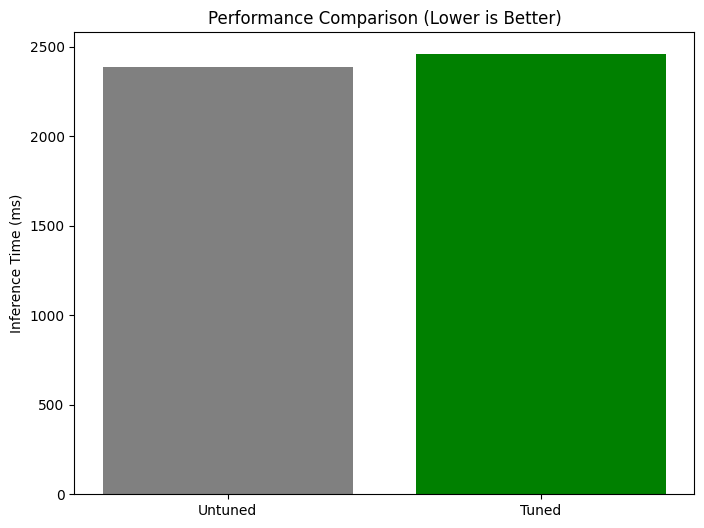

In [7]:
# ---* Step 7: Plot the results *---
print("\nGenerating performance comparison plot...")
labels = ["Untuned", "Tuned"]
times = [untuned_time_ms, tuned_time_ms]

plt.figure(figsize=(8, 6))
plt.bar(labels, times, color=["gray", "green"])
plt.ylabel("Inference Time (ms)")
plt.title("Performance Comparison (Lower is Better)")
plt.show()


In [25]:
# ---* Step 8: Visualize what changed between the original model and the tuned model *---
# - OPTION A
# For TIR IRModule (like after tuning low-level schedules)-here we can print the two IRs
#print(mod.script())
#print(mod_tuned.script())

# - OPTION B
#here we save the IR as a .py file because TVM’s IR can be represented as 
#valid Python code using TVMScript. If we do show_meta=True it also shows gibberish binary code etc..
with open("perf_files/untuned_ir.py", "w") as f:
    f.write(mod.script(show_meta=False))

with open("perf_files/tuned_ir.py", "w") as f:
    f.write(mod_tuned.script(show_meta=False))

print("IR scripts saved to 'untuned_ir.py' and 'tuned_ir.py'.")

IR scripts saved to 'untuned_ir.py' and 'tuned_ir.py'.


In [26]:
import difflib

diff = difflib.unified_diff(
    ir1, ir2,
    fromfile='Untuned', tofile='Tuned',
    lineterm=''
)

# Display the diff
diff_output = list(diff)
#print("\n".join(diff_output[:200]))  # limit output--my Jupyter crashes..

with open("perf_files/diff.txt", "w") as f:
    f.write("\n".join(diff_output))

print("Diff saved to 'diff.txt'")

Diff saved to 'diff.txt'


In [27]:
!diff -u untuned_ir.py tuned_ir.py | head -n 100

--- untuned_ir.py	2025-08-07 10:08:54
+++ tuned_ir.py	2025-08-07 10:08:54
@@ -5,63 +5,8 @@
 @I.ir_module
 class Module:
     @T.prim_func(private=True)
-    def add(lv28: T.Buffer((T.int64(1), T.int64(256), T.int64(56), T.int64(56)), "float32"), lv29: T.Buffer((T.int64(1), T.int64(256), T.int64(56), T.int64(56)), "float32"), T_add: T.Buffer((T.int64(1), T.int64(256), T.int64(56), T.int64(56)), "float32")):
-        T.func_attr({"tir.noalias": True})
-        # with T.block("root"):
-        for ax0, ax1, ax2, ax3 in T.grid(T.int64(1), T.int64(256), T.int64(56), T.int64(56)):
-            with T.block("T_add"):
-                v_ax0, v_ax1, v_ax2, v_ax3 = T.axis.remap("SSSS", [ax0, ax1, ax2, ax3])
-                T.reads(lv28[v_ax0, v_ax1, v_ax2, v_ax3], lv29[v_ax0, v_ax1, v_ax2, v_ax3])
-                T.writes(T_add[v_ax0, v_ax1, v_ax2, v_ax3])
-                T_add[v_ax0, v_ax1, v_ax2, v_ax3] = lv28[v_ax0, v_ax1, v_ax2, v_ax3] + lv29[v_ax0, v_ax1, v_ax2, v_ax3]
-
-    @T.prim_fun

In [30]:
# - OPTION C
#In the generated html file: if you see a red line → that line was present in 
#the untuned model, but removed during tuning. If you see a green line → it was added
#during tuning. If a line is yellow, it's modified.

def generate_html_diff(str1, str2, file_path="perf_files/ir_diff.html"):
    d = difflib.HtmlDiff(tabsize=4, wrapcolumn=80)
    html_diff = d.make_file(
        str1.splitlines(),
        str2.splitlines(),
        fromdesc='Original IR',
        todesc='Tuned IR',
        context=True,
        numlines=5
    )
    with open(file_path, "w") as f:
        f.write(html_diff)
    print(f"Diff saved to {file_path}")

ir1_str = mod.script(show_meta=False)
ir2_str = mod_tuned.script(show_meta=False)

generate_html_diff(ir1_str, ir2_str, "perf_files/ir_diff.html")

Diff saved to ir_diff.html
